In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from magrec.prop.Propagator import CurrentPropagator2d, CurrentDipolePropagator
import torch
from magrec.misc.plot import plot_n_components
from magrec.misc.sampler import GridSampler, NDGridPoints

import matplotlib.pyplot as plt

In [2]:
r_source = torch.zeros(200, 3)
r_source[:, 0] = torch.linspace(-2, 2, 200)

m_source = torch.zeros(200, 3)
m_source[:, 0] = 1 * (0.02 ** 3)

r_sensor = torch.zeros(100*100, 3)
r_sensor[:, 0:2] = GridSampler.sample_grid(100, 100, [-1, -1], [1, 1])
r_sensor[:, 2] = 0.2

In [3]:
J_Fourier_source = torch.zeros(1, 2, 100, 100)
J_Fourier_source[:, 0, :, 50] = 1
B_Fourier = CurrentPropagator2d(source_shape=(100, 100), dx=0.02, dy=0.02, height=0.2, layer_thickness=0.02)(J_Fourier_source)

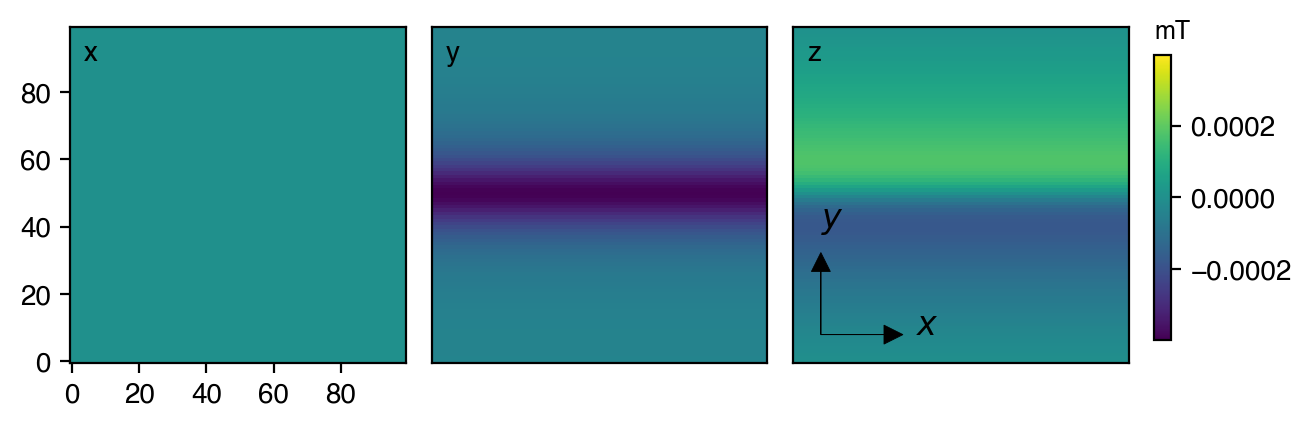

In [4]:
plot_n_components(B_Fourier, units="mT")

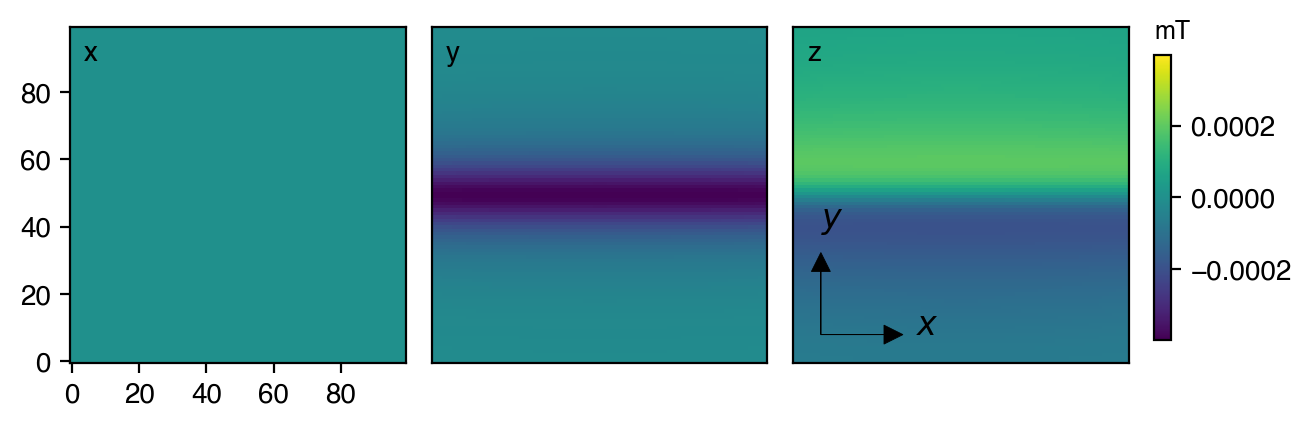

In [5]:
B = CurrentDipolePropagator.get_B_at_pts_from_J_at_pts(m_source, r_source, r_sensor)
B_grid = GridSampler.pts_to_grid(B, 100, 100)
plot_n_components(B_grid, units="mT")



## Reconstructing several current dipoles

Let's place current dipole on the vertices of a cube with diagonal [-1, -1, -1] and [1, 1, 1]. We will use the `CurrentDipolePropagator` class to find the field, add noise and then reconstruct dipole components. 

In [64]:
import plotly.graph_objects as go

fig = go.Figure()

In [30]:
r_sources = NDGridPoints.get_grid_pts(2, 2, 2, [-1, -1, -1], [1, 1, 1])

In [65]:
source_spheres = go.Scatter3d(
    x=r_sources[:, 0],
    y=r_sources[:, 1],
    z=r_sources[:, 2],
    mode="markers",
    marker=dict(
        size=5,
        color="red",
    ),
    name="source"
)

fig.add_trace(source_spheres)
fig.show()

In [66]:
r_sensors = NDGridPoints.get_grid_pts(3, 3, 3, [-2, -2, -2], [2, 2, 2])

# remove sensor inside the cube, i.e. where 2 < x, y, z < 2
r_sensors = r_sensors[torch.any(torch.abs(r_sensors) >= 2, dim=1)]

sensor_spheres = go.Scatter3d(
    x=r_sensors[:, 0],
    y=r_sensors[:, 1],
    z=r_sensors[:, 2],
    mode="markers",
    marker=dict(
        size=5,
        color="yellow",
    ),
    name="source"
)

fig.add_trace(sensor_spheres)
fig.show()

In [74]:
prop = CurrentDipolePropagator(r_sources, r_sensors)
F = prop.reshape_ffm_to_matrix(prop.ffm)
I = torch.linalg.inv(F.T @ F) @ F.T

In [78]:
F.shape

torch.Size([78, 24])

In [76]:
sources = torch.zeros(len(r_sources), 3)
sources[:, 2] = 0.3

field = prop.get_B_from_J(sources)

In [85]:
fig = go.Figure()

field_cones = go.Cone(
    x=r_sensors[:, 0],
    y=r_sensors[:, 1],
    z=r_sensors[:, 2],
    u=field[:, 0],
    v=field[:, 1],
    w=field[:, 2],
    colorscale="Blues",
    sizemode="absolute",
    sizeref=0.01,
    showscale=False,
    name="field"
)

source_cones = go.Cone(
    x=r_sources[:, 0],
    y=r_sources[:, 1],
    z=r_sources[:, 2],
    u=sources[:, 0],
    v=sources[:, 1],
    w=sources[:, 2],
    colorscale="Reds",
    sizemode="absolute",
    sizeref=0.1,
    showscale=False,
    name="source"
)

fig.add_trace(field_cones)
fig.add_trace(source_cones)

In [90]:
fig = go.Figure()


field_noise = field + 0.01 * torch.randn_like(field)
reconstructed_sources = prop.get_J_from_B(field_noise, method="lstsq")

field_cones = go.Cone(
    x=r_sensors[:, 0],
    y=r_sensors[:, 1],
    z=r_sensors[:, 2],
    u=field_noise[:, 0],
    v=field_noise[:, 1],
    w=field_noise[:, 2],
    colorscale="Blues",
    sizemode="absolute",
    sizeref=0.01,
    showscale=False,
    name="field"
)

source_cones = go.Cone(
    x=r_sources[:, 0],
    y=r_sources[:, 1],
    z=r_sources[:, 2],
    u=reconstructed_sources[:, 0],
    v=reconstructed_sources[:, 1],
    w=reconstructed_sources[:, 2],
    colorscale="Reds",
    sizemode="absolute",
    sizeref=0.1,
    showscale=False,
    name="source"
)

fig.add_trace(field_cones)
fig.add_trace(source_cones)

Show how noise in the data affects the reconstruction. Plot distribution of the noise in the data and the reconstructed dipole components.

In [116]:
# set plotting theme in matplotlib to seaborn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

n_experiments = 50

reconstruction_errors = torch.zeros(len(r_sources), 3, n_experiments)
field_noises = torch.zeros(len(r_sensors), 3, n_experiments)

for i in range(n_experiments):
    field_noises[:, :, i] = 0.01 * torch.randn_like(field)
    field_noise = field + field_noises[:, :, i]
    reconstructed_sources = prop.get_J_from_B(field_noise, method="lstsq")
    reconstruction_errors[:, :, i] = sources - reconstructed_sources
    
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
sns.kdeplot(reconstruction_errors.view(-1, len(r_sources)), fill=True, bw_adjust=0.5, aspect=1.5, palette="flare", ax=ax)

ax = fig.add_subplot(2, 1, 2)
sns.kdeplot(reconstruction_errors.view(-1, len(r_sensors)), fill=True, bw_adjust=0.5, aspect=1.5, palette="ch:start=.2,rot=-.3", ax=ax)

plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'add_subplot'

<Figure size 640x480 with 0 Axes>

In [100]:
reconstruction_errors.shape

torch.Size([10, 24])